In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

### Examining the Data

In [2]:
# Let's start with reading the data 

users_data = pd.read_pickle("../data/users_data_final.pkl")

In [3]:
# look at a preview of the data

users_data.head(n = 3)

,user_id,number_transactions,total_amount_usd,age,job,marital,education,default,housing,loan,contact,duration,campaign,pdays,previous,poutcome,term_deposit,date_joined,device
0,9231c446-cb16-4b2b-a7f7-ddfc8b25aaf6,3.0,2143.0,58,management,married,tertiary,False,True,False,None,261,1,-1,0,None,False,1998-08-23,mobile
1,bb92765a-08de-4963-b432-496524b39157,NaN,NaN,44,technician,single,secondary,False,True,False,None,151,1,-1,0,None,False,2008-07-15,desktop
2,573de577-49ef-42b9-83da-d3cfb817b5c1,2.0,2.0,33,entrepreneur,married,secondary,False,True,True,None,76,1,-1,0,None,False,2002-06-04,mobile


In [4]:
# look at the shape of the data (rows, columns)

users_data.shape

(45209, 19)

In [5]:
users_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45209 entries, 0 to 45215
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              45209 non-null  object        
 1   number_transactions  35210 non-null  float64       
 2   total_amount_usd     35210 non-null  float64       
 3   age                  45209 non-null  int64         
 4   job                  44921 non-null  object        
 5   marital              45209 non-null  object        
 6   education            43352 non-null  object        
 7   default              45209 non-null  bool          
 8   housing              45209 non-null  bool          
 9   loan                 45209 non-null  bool          
 10  contact              32191 non-null  object        
 11  duration             45209 non-null  int64         
 12  campaign             45209 non-null  int64         
 13  pdays                45209 non-

### Feature Engineering: Handling Missing Data

In [6]:
# identify missing values

def identify_missing_data(df):
    """
    This function is used to identify missing data
    
    @param df pandas DataFrame
    
    @return a DataFrame with the percentage of missing data for every feature and the data types
    """
    
    percent_missing = df.isnull().mean()
    
    missing_value_df = pd.DataFrame(percent_missing).reset_index() # convert to DataFrame
    missing_value_df = missing_value_df.rename(columns = {"index" : "feature",
                                                                0 : "percent_missing"}) # rename columns

    missing_value_df = missing_value_df.sort_values(by = ['percent_missing'], ascending = False) # sort the values
    
    data_types_df = pd.DataFrame(df.dtypes).reset_index().rename(columns = {"index" : "feature",
                                                                0 : "data_type"}) # rename columns
    
    missing_value_df = missing_value_df.merge(data_types_df, on = "feature") # join the dataframe with datatype
    
    missing_value_df.percent_missing = round(missing_value_df.percent_missing*100, 2) # format the percent_missing
    
    return missing_value_df



In [7]:
missing_value_df = identify_missing_data(users_data)
missing_value_df

,feature,percent_missing,data_type
0,poutcome,81.75,object
1,contact,28.80,object
2,total_amount_usd,22.12,float64
3,number_transactions,22.12,float64
4,education,4.11,object
5,job,0.64,object
6,device,0.21,object
7,date_joined,0.07,datetime64[ns]
8,campaign,0.00,int64
9,term_deposit,0.00,bool


In [8]:
# identify variables that have more than a threshold amount of missing data

threshold = 40

feature_to_drop = list(missing_value_df[missing_value_df.percent_missing > threshold].feature)
feature_to_drop

['poutcome']

In [9]:
# drop pouctome as it is missing 82% data

users_data.drop(feature_to_drop, axis = 1, inplace = True)

In [10]:
# check dropped

missing_value_df = identify_missing_data(users_data)
missing_value_df

,feature,percent_missing,data_type
0,contact,28.80,object
1,total_amount_usd,22.12,float64
2,number_transactions,22.12,float64
3,education,4.11,object
4,job,0.64,object
5,device,0.21,object
6,date_joined,0.07,datetime64[ns]
7,campaign,0.00,int64
8,term_deposit,0.00,bool
9,previous,0.00,int64


In [11]:
# identify variables that are categorical and have missing data

categorical_features_w_missing_values = list(missing_value_df[(missing_value_df.percent_missing > 0) &
                (missing_value_df.data_type == 'object')].feature)

categorical_features_w_missing_values 

['contact', 'education', 'job', 'device']

In [12]:
# Option 1 

users_data.contact.fillna("Unknown", inplace = True)
users_data.education.fillna("Unknown", inplace = True)
users_data.job.fillna("Unknown", inplace = True)
users_data.device.fillna("Unknown", inplace = True)

In [13]:
# Option 2 - use loops

# replace missing categorical values with "Unknown"

for i in categorical_features_w_missing_values :
    print(i)
    users_data[i].fillna("Unknown", inplace = True)

contact
education
job
device


In [14]:
# check missing values that are left

missing_value_df = identify_missing_data(users_data)
missing_value_df[(missing_value_df.percent_missing > 0)]

,feature,percent_missing,data_type
0,total_amount_usd,22.12,float64
1,number_transactions,22.12,float64
2,date_joined,0.07,datetime64[ns]


In [15]:
# replace missing numerical values with 0

users_data['number_transactions'].fillna(0, inplace = True)
users_data['total_amount_usd'].fillna(0, inplace = True)


In [16]:
# drop rows where date joined is null

users_data_cleaned = users_data[~users_data.date_joined.isnull()]

In [17]:
users_data_cleaned.isnull().sum()

# there should be no missing data

user_id                0
number_transactions    0
total_amount_usd       0
age                    0
job                    0
marital                0
education              0
default                0
housing                0
loan                   0
contact                0
duration               0
campaign               0
pdays                  0
previous               0
term_deposit           0
date_joined            0
device                 0
dtype: int64

In [18]:
# check the info on the data frame

users_data_cleaned.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 45179 entries, 0 to 45215
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              45179 non-null  object        
 1   number_transactions  45179 non-null  float64       
 2   total_amount_usd     45179 non-null  float64       
 3   age                  45179 non-null  int64         
 4   job                  45179 non-null  object        
 5   marital              45179 non-null  object        
 6   education            45179 non-null  object        
 7   default              45179 non-null  bool          
 8   housing              45179 non-null  bool          
 9   loan                 45179 non-null  bool          
 10  contact              45179 non-null  object        
 11  duration             45179 non-null  int64         
 12  campaign             45179 non-null  int64         
 13  pdays                45179 non-

### Feature Engineering: date_joined 

In [19]:
# Did you come up with a way to engineer date joined variable?
# if not drop this variable

users_data_cleaned.drop(['date_joined'], axis = 1, inplace = True)


/Users/shaq/.pyenv/versions/3.8.10/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [20]:
users_data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45179 entries, 0 to 45215
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              45179 non-null  object 
 1   number_transactions  45179 non-null  float64
 2   total_amount_usd     45179 non-null  float64
 3   age                  45179 non-null  int64  
 4   job                  45179 non-null  object 
 5   marital              45179 non-null  object 
 6   education            45179 non-null  object 
 7   default              45179 non-null  bool   
 8   housing              45179 non-null  bool   
 9   loan                 45179 non-null  bool   
 10  contact              45179 non-null  object 
 11  duration             45179 non-null  int64  
 12  campaign             45179 non-null  int64  
 13  pdays                45179 non-null  int64  
 14  previous             45179 non-null  int64  
 15  term_deposit         45179 non-null 

### Feature Engineering: Categorical Data

In [21]:
def identify_number_categories(df):
    """This definition can be used to identify the number of categories of every categorical feature 
    
    @param df DataFrame 
    
    @param returns a DataFrame with the categorical features and number of categories"""

    categorical_columns = list(df.select_dtypes(['object']).columns)

    cat_df = []

    for c in categorical_columns:
        cat_df.append({"categorical_feature": c,
                       "number_categories": len(df[c].value_counts(dropna = False))
                    })
        
    return pd.DataFrame(cat_df)

In [22]:
cat_df = identify_number_categories(users_data_cleaned)
cat_df

,categorical_feature,number_categories
0,user_id,45179
1,job,12
2,marital,3
3,education,4
4,contact,3
5,device,4


In [23]:
# drop catgeorical features where number_categories is greater than 10
features_to_drop = list(cat_df[cat_df.number_categories > 10].categorical_feature)
print(features_to_drop)

['user_id', 'job']


In [24]:
users_data_cleaned.drop(features_to_drop, axis = 1, inplace = True)

/Users/shaq/.pyenv/versions/3.8.10/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [25]:
# check the variables were dropped

list(users_data_cleaned)

['number_transactions',
 'total_amount_usd',
 'age',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'term_deposit',
 'device']

In [26]:
# identify all the categorical variables 

categorical_columns = list(users_data_cleaned.select_dtypes(['object']).columns)

categorical_columns

['marital', 'education', 'contact', 'device']

In [27]:
users_data_cleaned.marital.value_counts()

married     27195
single      12781
divorced     5203
Name: marital, dtype: int64

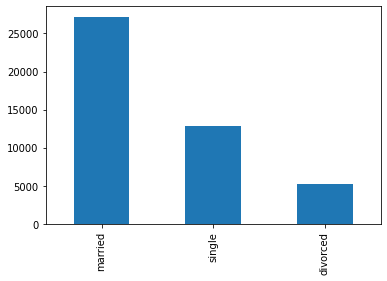

In [28]:
# look at the distribution of one of the categorical variables

users_data_cleaned.marital.value_counts().plot(kind = 'bar');

In [29]:
# encode the categorical variables
# lots of ways to do that, but we will use pd.get_dummies function
# lets start with marital
# we use pandas get dummies function

pd.get_dummies(users_data_cleaned['marital'], prefix='marital')

# you can also one of dummy variables, as it can be inferred by the other dummy variables

,marital_divorced,marital_married,marital_single
0,0,1,0
1,0,0,1
2,0,1,0
3,0,1,0
4,0,0,1
...,...,...,...
45211,0,1,0
45212,1,0,0
45213,0,1,0
45214,0,1,0


In [30]:
# How to encode variables

# step 1. dummify the non numerical variable

marital_dummies = pd.get_dummies(users_data_cleaned.marital, prefix='marital')
marital_dummies

,marital_divorced,marital_married,marital_single
0,0,1,0
1,0,0,1
2,0,1,0
3,0,1,0
4,0,0,1
...,...,...,...
45211,0,1,0
45212,1,0,0
45213,0,1,0
45214,0,1,0


In [31]:
# step 2. join the dummy variables to our data frame

users_data_cleaned_w_dummies = pd.concat([users_data_cleaned, marital_dummies], axis = 1)
users_data_cleaned_w_dummies

,number_transactions,total_amount_usd,age,marital,education,default,housing,loan,contact,duration,campaign,pdays,previous,term_deposit,device,marital_divorced,marital_married,marital_single
0,3.0,2143.0,58,married,tertiary,False,True,False,Unknown,261,1,-1,0,False,mobile,0,1,0
1,0.0,0.0,44,single,secondary,False,True,False,Unknown,151,1,-1,0,False,desktop,0,0,1
2,2.0,2.0,33,married,secondary,False,True,True,Unknown,76,1,-1,0,False,mobile,0,1,0
3,0.0,0.0,47,married,Unknown,False,True,False,Unknown,92,1,-1,0,False,tablet,0,1,0
4,1.0,1.0,33,single,Unknown,False,False,False,Unknown,198,1,-1,0,False,mobile,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45211,2.0,825.0,51,married,tertiary,False,False,False,cellular,977,3,-1,0,True,desktop,0,1,0
45212,4.0,1729.0,71,divorced,primary,False,False,False,cellular,456,2,-1,0,True,desktop,1,0,0
45213,2.0,5715.0,72,married,secondary,False,False,False,cellular,1127,5,184,3,True,mobile,0,1,0
45214,0.0,0.0,57,married,secondary,False,False,False,telephone,508,4,-1,0,False,desktop,0,1,0


In [32]:
# step 3. drop the marital variable

users_data_cleaned_w_dummies.drop(['marital'], axis = 1, inplace = True)

In [33]:
users_data_cleaned_w_dummies.head()

,number_transactions,total_amount_usd,age,education,default,housing,loan,contact,duration,campaign,pdays,previous,term_deposit,device,marital_divorced,marital_married,marital_single
0,3.0,2143.0,58,tertiary,False,True,False,Unknown,261,1,-1,0,False,mobile,0,1,0
1,0.0,0.0,44,secondary,False,True,False,Unknown,151,1,-1,0,False,desktop,0,0,1
2,2.0,2.0,33,secondary,False,True,True,Unknown,76,1,-1,0,False,mobile,0,1,0
3,0.0,0.0,47,Unknown,False,True,False,Unknown,92,1,-1,0,False,tablet,0,1,0
4,1.0,1.0,33,Unknown,False,False,False,Unknown,198,1,-1,0,False,mobile,0,0,1


In [34]:
# Or use this definition to drop the variables 

def one_hot(df, categorical_cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode 
    @return a DataFrame with one-hot encoding
    """
    
    for c in categorical_cols:
        dummies = pd.get_dummies(df[c], prefix=c)
        df = pd.concat([df, dummies], axis=1)
        df.drop(c, axis = 1, inplace = True)
    
    return df

In [35]:
# pass in the variables that you want to encode

categorical_columns = ['marital', 'education', 'contact', 'device']

users_data_cleaned_w_encoding = one_hot(users_data_cleaned, categorical_columns)

In [36]:
# preview the data

users_data_cleaned_w_encoding.head(n = 5)

,number_transactions,total_amount_usd,age,default,housing,loan,duration,campaign,pdays,previous,...,education_primary,education_secondary,education_tertiary,contact_Unknown,contact_cellular,contact_telephone,device_Unknown,device_desktop,device_mobile,device_tablet
0,3.0,2143.0,58,False,True,False,261,1,-1,0,...,0,0,1,1,0,0,0,0,1,0
1,0.0,0.0,44,False,True,False,151,1,-1,0,...,0,1,0,1,0,0,0,1,0,0
2,2.0,2.0,33,False,True,True,76,1,-1,0,...,0,1,0,1,0,0,0,0,1,0
3,0.0,0.0,47,False,True,False,92,1,-1,0,...,0,0,0,1,0,0,0,0,0,1
4,1.0,1.0,33,False,False,False,198,1,-1,0,...,0,0,0,1,0,0,0,0,1,0


In [37]:
print(users_data_cleaned.shape)
print(users_data_cleaned_w_encoding.shape)

# you should have ten new columns

(45179, 15)
(45179, 25)


In [38]:
users_data_cleaned_w_encoding.info()

# Check all the data is numerical
# If not, do not continue

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45179 entries, 0 to 45215
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   number_transactions  45179 non-null  float64
 1   total_amount_usd     45179 non-null  float64
 2   age                  45179 non-null  int64  
 3   default              45179 non-null  bool   
 4   housing              45179 non-null  bool   
 5   loan                 45179 non-null  bool   
 6   duration             45179 non-null  int64  
 7   campaign             45179 non-null  int64  
 8   pdays                45179 non-null  int64  
 9   previous             45179 non-null  int64  
 10  term_deposit         45179 non-null  bool   
 11  marital_divorced     45179 non-null  uint8  
 12  marital_married      45179 non-null  uint8  
 13  marital_single       45179 non-null  uint8  
 14  education_Unknown    45179 non-null  uint8  
 15  education_primary    45179 non-null 

### Building our Linear Regression Model

In [39]:
# Step 1. Define the target and features
# A supervised machine learning algorithm requires both - uses historical data to uncover relationships between other features of your dataset and the target.

target_data = users_data_cleaned_w_encoding["total_amount_usd"]
features = users_data_cleaned_w_encoding.drop(["total_amount_usd"], axis = 1)


/Users/shaq/.pyenv/versions/3.8.10/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


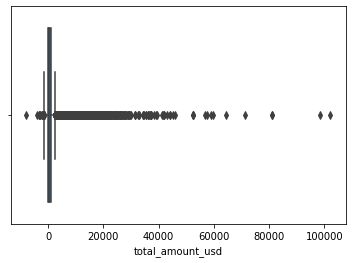

In [40]:
sns.boxplot(target_data);

In [41]:
# Step 2. Split the data into a training and test set
# The training data is the data we use to train the machine learning algorithm
# the test set is used to evaluate the prediction

# using this handy function from scikit-learm to split the data into a training and test dataset
# we can adjust the test size to our needs, but it's best practise to train the model on 70 - 80% of the data

X_train, X_test, y_train, y_test = train_test_split(
                                                features, 
                                                target_data,
                                                test_size = 0.2, 
                                                random_state = 42)


In [42]:
X_train.shape

(36143, 24)

In [43]:
X_test.shape

(9036, 24)

In [44]:
scaler = StandardScaler()
scaler.fit(X_train)

# transform training data
X_train_scaled = scaler.transform(X_train)
X_train_scaled 

array([[-0.29308415, -1.30836434, -0.13606742, ..., -0.60421153,
         0.80108942, -0.37168148],
       [-0.02661519, -0.65081386,  7.34929769, ...,  1.65504952,
        -1.24830009, -0.37168148],
       [ 0.23985377,  0.38247975, -0.13606742, ...,  1.65504952,
        -1.24830009, -0.37168148],
       ...,
       [-0.02661519, -1.12049278, -0.13606742, ..., -0.60421153,
         0.80108942, -0.37168148],
       [-0.82602207, -0.74474964, -0.13606742, ..., -0.60421153,
         0.80108942, -0.37168148],
       [-0.29308415,  0.28854397, -0.13606742, ..., -0.60421153,
         0.80108942, -0.37168148]])

In [45]:
# print the shape of the training data

print("Training Data")
print(X_train.shape)
print(y_train.shape)

Training Data
(36143, 24)
(36143,)


In [46]:
# print the shape of the scale training data

print("Training Data")
print(X_train_scaled.shape)
print(y_train.shape)

Training Data
(36143, 24)
(36143,)


In [47]:
# print the shape of the test data 

print("\nTest Data")
print(X_test.shape)
print(y_test.shape)


Test Data
(9036, 24)
(9036,)


In [48]:
# Step 3. Import the Linear Regression model from sklearn

lr = LinearRegression()

In [49]:
# Step 4. Fit the model on the scaled training data

lr.fit(X_train_scaled, y_train) 

# This is your machine learning model!

LinearRegression()

In [50]:
# Step 5. Make predictions on unseen data

y_pred = lr.predict(X_test) 
y_pred

array([-6.34369265e+16, -5.87271227e+16, -6.09103173e+16, ...,
       -6.34369265e+16, -6.30775373e+16, -6.14827182e+16])

In [51]:
print("first five predicted total amounts:", y_pred[0:5])
print("first five actual total amounts:", list(y_test[0:5]))

first five predicted total amounts: [-6.34369265e+16 -5.87271227e+16 -6.09103173e+16 -6.05213691e+16
 -6.12537319e+16]
first five actual total amounts: [3025.0, 197.0, 5057.0, 378.0, 1230.0]


In [52]:
# Step 6: Evaluate the model performance

r2_score(y_test, y_pred)

# R^2 (coefficient of determination) regression score function.
# Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). 

# Pretty close to 0. Lets see over the next few weeks we can improve the score.


-5.147718415224394e+26

In [53]:
mean_absolute_error(y_test, y_pred)

6.005473615267066e+16

In [54]:
mean_squared_error(y_test, y_pred)

3.6406033460597487e+33

In [55]:
# question: what sort of results do you get if we do not scale the data?

lr = LinearRegression() # importing the machine learning algorithm
lr.fit(X_train, y_train) # fitting the training data to algorithm


LinearRegression()

In [56]:
# make predictions based on the trained models
y_pred = lr.predict(X_test)
y_pred

array([1573.21790537, 1212.91978156, 1041.89517373, ...,  915.46035613,
       1037.4034092 ,  889.18459734])

In [57]:
# evaluating the model using evaluation metrics
# r2_score
r2_score(y_test, y_pred)

0.024612036929752668

In [58]:
mean_squared_error(y_test, y_pred)

6898203.039929008

In [59]:
# Question: Are we able to build a model which improves the r2 score? What could we do?